In [5]:
# [1]: Importing libraries
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# [2]: Loading the dataset
dataset_df = pd.read_csv('/content/Train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (20, 6)


In [7]:
# [3]: Checking first entries
dataset_df.head(3)

# [4]: Droping ID column
# dataset_df = dataset_df.drop('Id', axis=1) # Id column was dropped when loading
dataset_df.head(3)

# [5]: Inspecting feature types
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Location   20 non-null     object
 1   SqFt       20 non-null     int64 
 2   Bedrooms   20 non-null     int64 
 3   Bathrooms  20 non-null     int64 
 4   YearBuilt  20 non-null     int64 
 5   SalePrice  20 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 1.1+ KB


count    2.000000e+01
mean     3.577500e+07
std      8.685249e+06
min      2.100000e+07
25%      3.175000e+07
50%      3.400000e+07
75%      4.125000e+07
max      5.200000e+07
Name: SalePrice, dtype: float64


/tmp/ipython-input-3223225524.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha':0.4})


array([[<Axes: title={'center': 'SqFt'}>,
        <Axes: title={'center': 'Bedrooms'}>],
       [<Axes: title={'center': 'Bathrooms'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'SalePrice'}>, <Axes: >]], dtype=object)

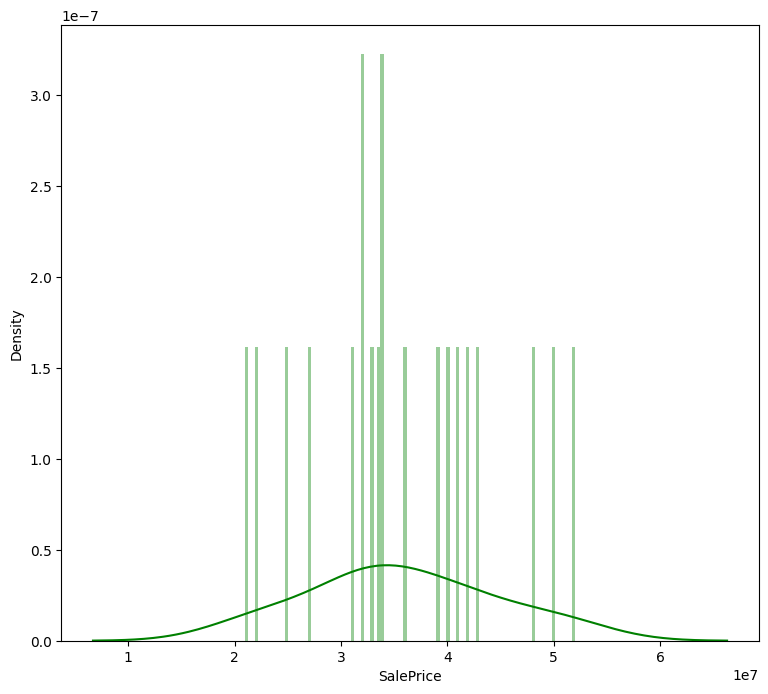

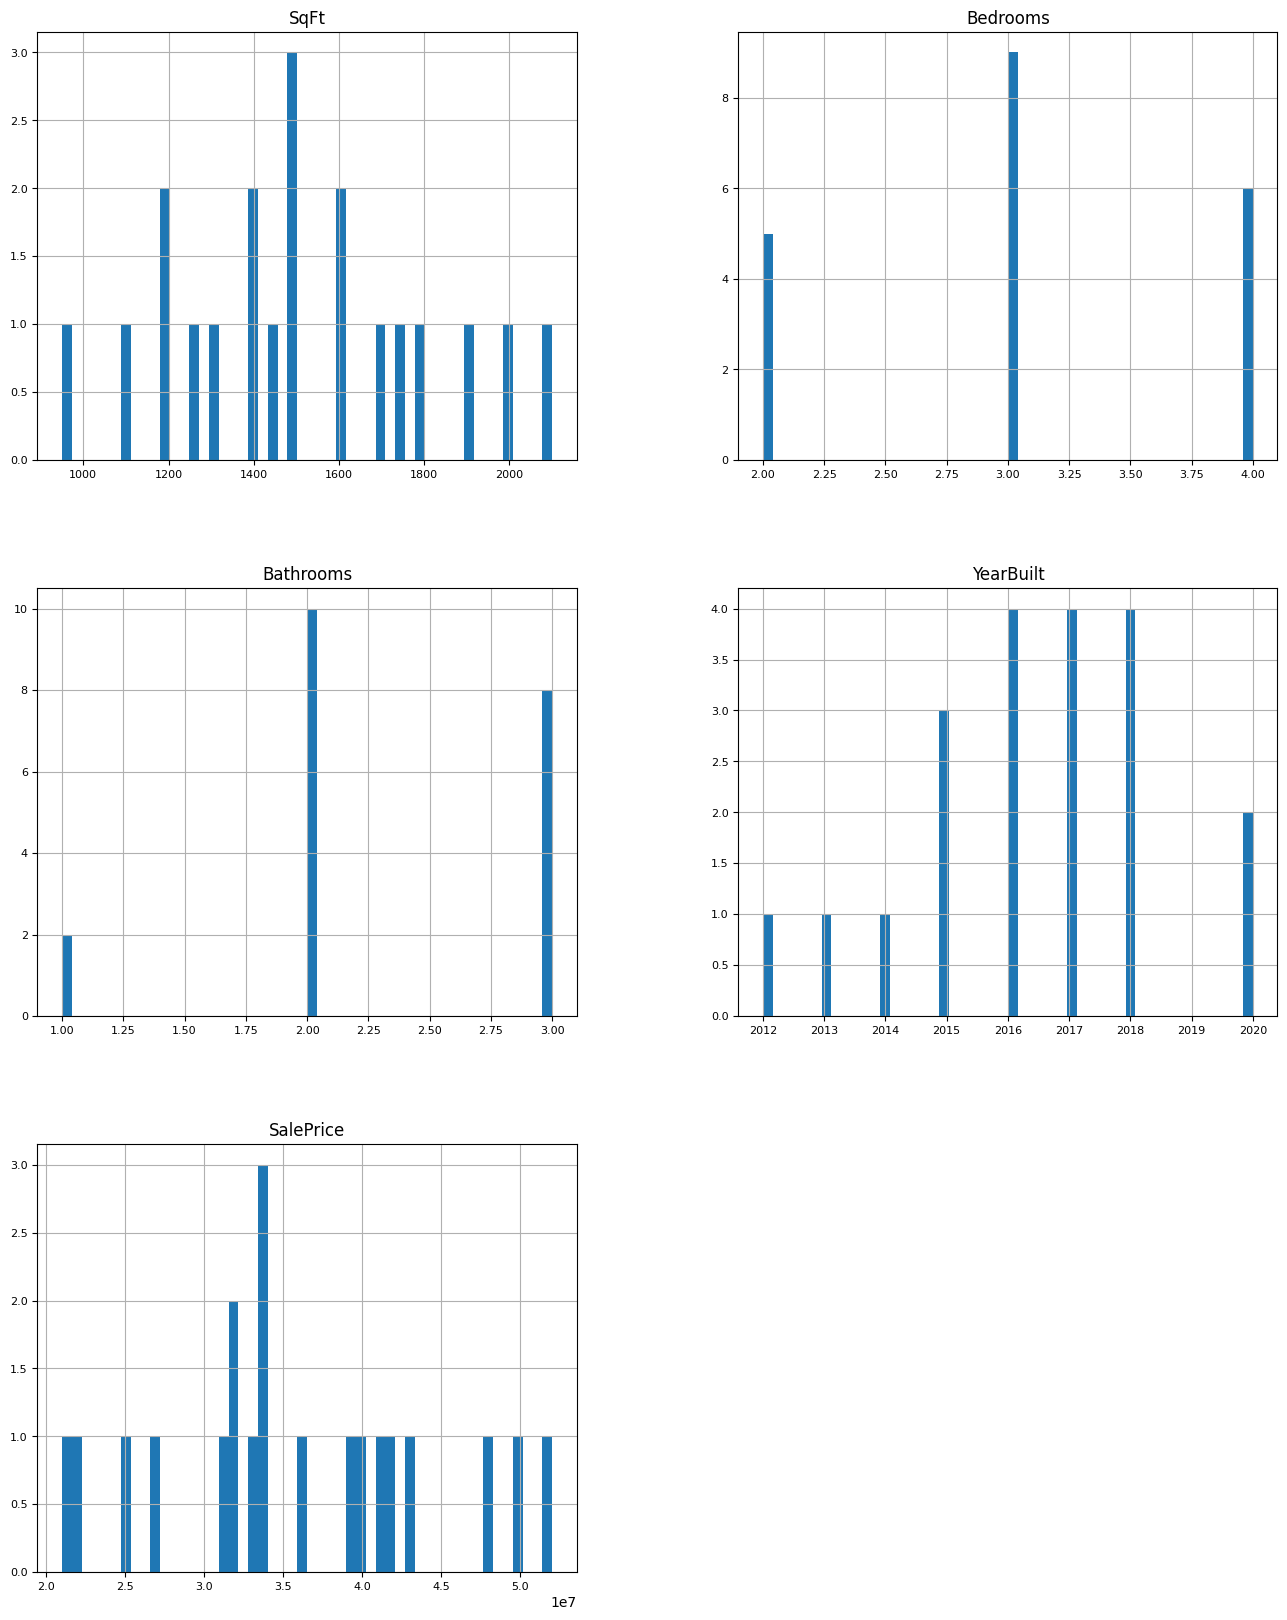

In [8]:
# [6]: House price distribution
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha':0.4})

# [7]: Listing data types from dataset
list(set(dataset_df.dtypes.tolist()))

# [8]: Only numerical features
df_num = dataset_df.select_dtypes(include=['float64', 'int64'])
df_num.head()

# [9]: Histograms for numerical features
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [9]:
# [10]: Spliting into train and test set
import numpy as np
def split_dataset(dataset, test_ratio=0.30):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]
train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(len(train_ds_pd), len(valid_ds_pd)))

12 examples in training, 8 examples in testing.


In [10]:
# [11]: Converting dataframe to TF dataset (regression)
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

In [11]:
# [12]: Listing available models
tfdf.keras.get_all_models()

# [13]: Creating random forest model
rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

# [14]: Training model
rf.fit(x=train_ds)

# [15]: Visualizing a tree
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

Use /tmp/tmpnr_o3lar as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.847512. Found 12 examples.
Training model...
Model trained in 0:00:00.049560
Compiling model...
Model compiled.


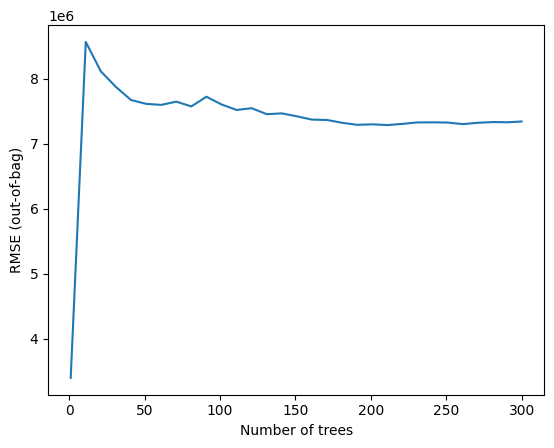

1/1 [==============================] - 0s 328ms/step - loss: 0.0000e+00 - mse: 60088576376832.0000
loss: 0.0000
mse: 60088576376832.0000


In [12]:
# [16]: Training logs plot
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

# [17]: Inspecting OOB evaluation
inspector = rf.make_inspector()
inspector.evaluation()

# [18]: Validation evaluation
evaluation = rf.evaluate(x=valid_ds, return_dict=True)
for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

In [13]:
# [19]: Variable importance types
inspector = rf.make_inspector()
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

# [20]: Displaying variable importances
inspector.variable_importances()["NUM_AS_ROOT"]

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


[("SqFt" (1; #3), 187.0),
 ("YearBuilt" (1; #4), 56.0),
 ("Bathrooms" (1; #0), 48.0),
 ("Bedrooms" (1; #1), 4.0)]

In [25]:
# [21]: Predicting on competition test data
test_df = pd.read_csv('/content/Test.csv')
ids = pd.Series(list(range(1, 21)))  # Ensures 20 IDs
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, task=tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)

1/1 [==============================] - 0s 50ms/step


In [24]:
# [22]: OutPut(Sample Submission)
output = pd.DataFrame({'Id': ids, 'SalePrice': preds.squeeze()})
output.to_csv('/content/sample_submission.csv', index=False)
print(output)


    Id   SalePrice
0    1  31662874.0
1    2  38112656.0
2    3  33262212.0
3    4  30460022.0
4    5  37694012.0
5    6  36552660.0
6    7  30537400.0
7    8  38112656.0
8    9  33262212.0
9   10  31543152.0
10  11  33018392.0
11  12  35350676.0
12  13  35616800.0
13  14  37694012.0
14  15  30460022.0
15  16  35512844.0
16  17  33544888.0
17  18  38112656.0
18  19  38112656.0
19  20  35300296.0
